# <center>**Endogeneity in the CAPM**</center>
### <center>Basic numerical examples, impact on correlations and VaR</center>

This notebook presents numerical experiments for the models introduced in the main README of the repository. Returns of market factors are simulated according to the Data Generating Processes (DGPs) defined, and respective estimators (or their expected values) are obtained to show the bias due to the endogeneity. In particular, the impact on correlations and Value-at-Risk (VaR) is assessed.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import scipy.stats as sps
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller, kpss
from mpl_toolkits import mplot3d
from matplotlib import cm, colors
import matplotlib.image as mpimg

## Simple framework

Initially, we assume that all weights, volatilities and (true) betas are equal.

### Basic numerical examples

Parameters

In [52]:
beta = 0.3    # true beta in the actual DGP
n = 20        # number of index components
N = 100       # number of market factors in the cluster
T = 250       # time horizon used for calibration

Systematic and idiosyncratic components simulation

In [53]:
s = np.random.normal(0, 1, T)
idio = np.random.normal(0, 1, (N,T))

Market factors returns calculation

In [54]:
r = np.array([beta * s + np.sqrt(1 - beta ** 2) * idio[i] for i in range(N)])

Index returns calculation

In [55]:
idx = np.array([np.mean(r[:n][:, i]) for i in range(T)])

Correlations between risk factors and index returns

In [56]:
cors = np.array([np.corrcoef(idx, r[i])[0, 1] for i in range(N)])

In [57]:
cors[:n].mean(), cors[n:].mean()

(0.3732263346476643, 0.23595106128928936)

In [58]:
np.sqrt(((n - 1) * beta ** 2 + 1) / n), (beta ** 2) / np.sqrt(((n - 1) * beta ** 2 + 1) / n)

(0.36810324638611924, 0.24449662121587254)

Index variance and standard deviation

In [59]:
idx.var(), ((n - 1) * beta ** 2 + 1) / n

(0.13847904330179306, 0.1355)

In [60]:
idx.std(), np.sqrt(((n - 1) * beta ** 2 + 1) / n)

(0.37212772444658443, 0.36810324638611924)

Average correlations between risk factors returns (obtained directly)

In [61]:
np.mean([np.mean([np.corrcoef(r[j], r[i])[0, 1] for i in range(N) if i != j]) for j in range(N)])

0.0863524401148104

#### 1000 simulations

Consider the following numerical example. We set the following parameters: $\beta=0.3$, $n=20$, $N=100$, $T=250$. We simulate the returns 1000 times and calculate means and standard deviations of the following estimators:
- $\hat{\sigma_I}$ ('sigma_I') - volatility (std dev) of index returns
- $\overline{\hat{\rho_{r_I,r_{k \leq n}}}}$ ('mean_rho_com') - average correlation between index and its component market factors
- $\overline{\hat{\rho_{r_I,r_{k \gt n}}}}$ ('mean_rho_ncom') - average correlation between index and non-component market factors

We compare obtained results with the expected values of these estimators derived analytically in the README.

In [62]:
idx_std = []
cors_com_m = []
cors_ncom_m = []

for j in range(1000):

    s = np.random.normal(0, 1, T)
    idio = np.random.normal(0, 1, (N,T))
    r = np.array([beta * s + np.sqrt(1 - beta ** 2) * idio[i] for i in range(N)])
    idx = np.array([np.mean(r[:n][:, i]) for i in range(T)])
    cors = np.array([np.corrcoef(idx, r[i])[0, 1] for i in range(N)])

    idx_std.append(idx.std())
    cors_com_m.append(cors[:n].mean())
    cors_ncom_m.append(cors[n:].mean())

In [63]:
pd.DataFrame({'Value': ['Expected value', 'Mean', 'Standard deviation'], 'sigma_I': [np.sqrt(((n - 1) * beta ** 2 + 1) / n), np.mean(idx_std), np.std(idx_std)], 'mean_rho_com': [np.sqrt(((n - 1) * beta ** 2 + 1) / n), np.mean(cors_com_m), np.std(cors_com_m)], 'mean_rho_ncom': [(beta ** 2) / np.sqrt(((n - 1) * beta ** 2 + 1) / n), np.mean(cors_ncom_m), np.std(cors_ncom_m)]}).set_index('Value').round(4)

,sigma_I,mean_rho_com,mean_rho_ncom
Value,,,
Expected value,0.3681,0.3681,0.2445
Mean,0.3670,0.3674,0.2448
Standard deviation,0.0159,0.0141,0.0157


### Impact on correlations

For $N=100$ and given ranges of $n$ and $\beta$, we analyze the relative and absolute bias of the estimator of correlation between index component and non-component market factor return and systematic component return. That is, we calculate: 
- $ \left( \frac{\rho_{r_I, r_{k \leq n} }}{\beta} − 1 \right) × 100 \% $ - relative bias of the estimator of correlation between index component market factor return and systematic component return
- $ \left( \frac{\rho_{r_I, r_{k \gt n} }}{\beta} − 1 \right) × 100 \% $ - relative bias of the estimator of correlation between non-component market factor return and systematic component return
- $ \rho_{r_I, r_{k \leq n} } - \beta $ - absolute bias of the estimator of correlation between index component market factor return and systematic component return
- $ \rho_{r_I, r_{k \gt n} } - \beta $ - absolute bias of the estimator of correlation between non-component market factor return and systematic component return

Note that, since all market factors and systematic component returns have variance equal to 1, the true correlation is equal to the true $\beta$.

In [64]:
n_range = np.arange(10, 91, 5)
beta_range = np.arange(0.1, 0.91, 0.1)
cor_mis_rel_com = np.zeros((len(n_range), len(beta_range)))
cor_mis_rel_ncom = np.zeros((len(n_range), len(beta_range)))
cor_mis_abs_com = np.zeros((len(n_range), len(beta_range)))
cor_mis_abs_ncom = np.zeros((len(n_range), len(beta_range)))

for i, n in enumerate(n_range):
    for j, beta in enumerate(beta_range):

        cor_mis_rel_com[i, j] = np.sqrt(((n - 1) * beta ** 2 + 1) / n) / beta - 1
        cor_mis_rel_ncom[i, j] = ((beta ** 2) / np.sqrt(((n - 1) * beta ** 2 + 1) / n)) / beta - 1

        cor_mis_abs_com[i, j] = np.sqrt(((n - 1) * beta ** 2 + 1) / n) - beta
        cor_mis_abs_ncom[i, j] = ((beta ** 2) / np.sqrt(((n - 1) * beta ** 2 + 1) / n)) - beta

Relative bias of the estimator of correlation between index component market factor return and systematic component return:

In [65]:
#cor_mis_rel_com.round(2)

In [66]:
#pd.DataFrame(cor_mis_rel_com).to_csv()

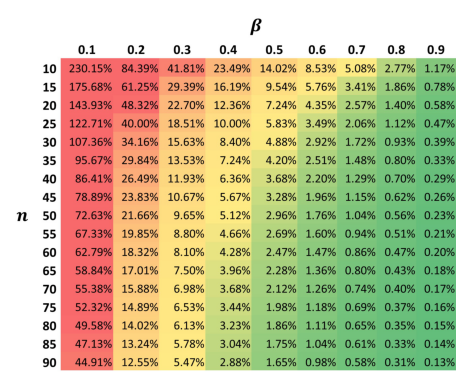

In [67]:
imgplot = plt.imshow(mpimg.imread('cor_mis_rel_com.jpg'))
plt.axis('off')
plt.show()

Relative bias of the estimator of correlation between non-component market factor return and systematic component return:

In [68]:
#cor_mis_rel_ncom.round(2)

In [69]:
#pd.DataFrame(cor_mis_rel_ncom).to_csv()

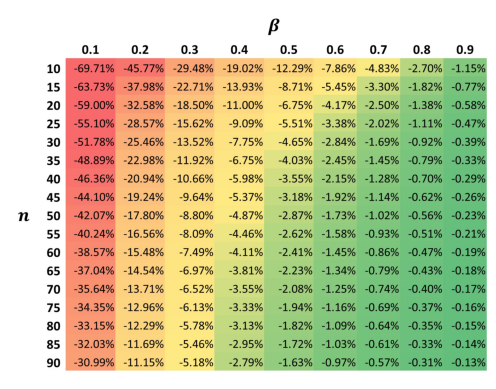

In [70]:
imgplot = plt.imshow(mpimg.imread('cor_mis_rel_ncom.jpg'))
plt.axis('off')
plt.show()

Absolute bias of the estimator of correlation between index component market factor return and systematic component return:

In [71]:
#cor_mis_abs_com.round(2)

In [72]:
#pd.DataFrame(cor_mis_abs_com).to_csv()

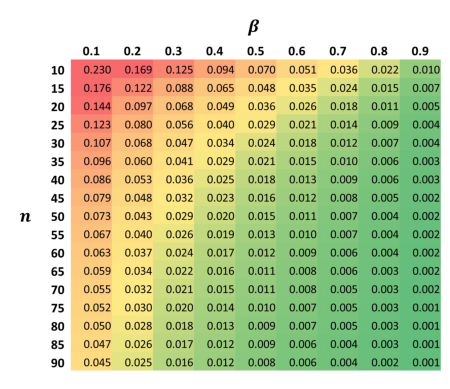

In [73]:
imgplot = plt.imshow(mpimg.imread('cor_mis_abs_com.jpg'))
plt.axis('off')
plt.show()

Absolute bias of the estimator of correlation between non-component market factor return and systematic component return:

In [74]:
#cor_mis_abs_ncom.round(2)

In [75]:
#pd.DataFrame(cor_mis_abs_ncom).to_csv()

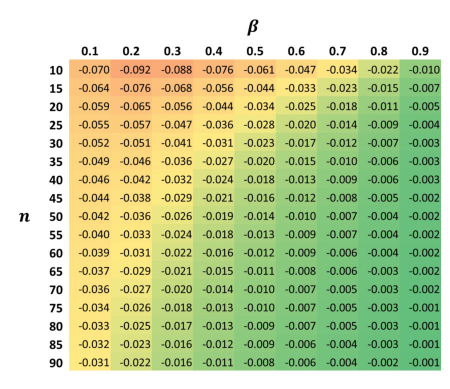

In [76]:
imgplot = plt.imshow(mpimg.imread('cor_mis_abs_ncom.jpg'))
plt.axis('off')
plt.show()

### Impact on VaR

In this section we assess the impact of endogeneity on VaR estimation. Endogeneity may be relevant for VaR estimation if the correlations between market factors are obtained through the systematic component. More specifically, if we assume a CAPM-like (or Beta-Model-like) structure of dependence between market factors, as we did here, correlation between any two market factors in a given cluster can be obtained as a product of correlations of these market factors and systematic component, i.e., $ \rho_{r_i,r_j} = \rho_{r_i,r_s} \rho_{r_s,r_j} $. This is a standard practice, which is commonly used in the industry, because it significantly reduces risk dimensionality and computational effort. We will compare the true VaR (obtained analytically based on assumed DGPs) with VaRs obtained through the systematic component with and without estimator adjustment proposed earlier, as well as with VaR obtained with direct covariance estimator.

More specifically, we consider 99% VaRs obtained in the following ways:

1) True VaR
   $$ VaR_{true} = \sqrt{e^T \begin{bmatrix} 
    1 & \dots  & \beta^{2} \\
    \vdots & \ddots & \vdots \\
    \beta^{2} & \dots  & 1 
    \end{bmatrix} e} × \phi ^{−1} (0.99) $$
   
2) VaR based on covariance estimator obtained through systematic component
   $$ VaR_{cov\_sys} = \sqrt{e^T \begin{bmatrix} 
    \hat{\sigma_{1}^{2}} & \dots  & \hat{\rho_{r_I,r_1}} \hat{\sigma_{1}} \hat{\rho_{r_I,r_N}} \hat{\sigma_{N}} \\
    \vdots & \ddots & \vdots \\
    \hat{\rho_{r_I,r_N}} \hat{\sigma_{N}} \hat{\rho_{r_I,r_1}} \hat{\sigma_{1}} & \dots  & \hat{\sigma_{N}^{2}} 
    \end{bmatrix} e} × \phi ^{−1} (0.99) $$
   
3) VaR based on adjusted covariance estimator obtained through systematic component
   $$ VaR_{cov\_sys\_adj} = \sqrt{e^T \begin{bmatrix} 
    \hat{\sigma_{1}^{2}} & \dots  & \hat{\rho_{r_s,r_1}} \hat{\sigma_{1}} \hat{\rho_{r_s,r_N}} \hat{\sigma_{N}} \\
    \vdots & \ddots & \vdots \\
    \hat{\rho_{r_s,r_N}} \hat{\sigma_{N}} \hat{\rho_{r_s,r_1}} \hat{\sigma_{1}} & \dots  & \hat{\sigma_{N}^{2}} 
    \end{bmatrix} e} × \phi ^{−1} (0.99) $$

4) VaR based on standard covariance estimator
   $$ VaR_{cov} = \sqrt{e^T \begin{bmatrix} 
    \hat{\sigma_{1}^{2}} & \dots  & \hat{cov \left(r_1,r_N \right)} \\
    \vdots & \ddots & \vdots \\
    \hat{cov \left(r_N,r_1 \right)} & \dots  & \hat{\sigma_{N}^{2}} 
    \end{bmatrix} e} × \phi ^{−1} (0.99) $$

In each case we assume all sensitivities are equal to 1, i.e., $ e = \begin{bmatrix} 
    1 \\
    \vdots \\
    1 
    \end{bmatrix}_{𝑁×1} $.

Parameters

In [77]:
beta = 0.3
n = 20
N = 100
T = 250

True covariance matrix and the resulting VaR

In [78]:
true_cov = np.ones((N,N))
for i in range(N):
    for j in range(N):
        if i != j:
            true_cov[i,j] = beta ** 2

In [87]:
true_VaR = np.sqrt(np.ones(N).dot(true_cov).dot(np.ones(N))) * norm.ppf(0.99)
true_VaR

73.2337857902679

Covariance matrix estimator obtained through systematic component and the resulting VaR

In [80]:
emp_cov = np.ones((N,N))
for i in range(N):
    for j in range(N):
        if i != j:
            emp_cov[i,j] = cors[i] * r[i].std() * cors[j] * r[j].std()
        else:
            emp_cov[i,j] = r[i].var()

In [81]:
np.sqrt(np.ones(N).dot(emp_cov).dot(np.ones(N))) * norm.ppf(0.99)

67.71563488929235

Adjusted covariance matrix estimator obtained through systematic component and the resulting VaR

In [82]:
cors_adj = np.zeros(N)
cors_adj[:n] = np.sqrt((n * cors[:n] ** 2 - 1) / (n - 1))
cors_adj[n:] = np.sqrt(cors[n:] * idx.std())

In [83]:
emp_cov_adj = np.ones((N,N))
for i in range(N):
    for j in range(N):
        if i != j:
            emp_cov_adj[i,j] = cors_adj[i] * r[i].std() * cors_adj[j] * r[j].std()
        else:
            emp_cov_adj[i,j] = r[i].var()

In [84]:
np.sqrt(np.ones(N).dot(emp_cov_adj).dot(np.ones(N))) * norm.ppf(0.99)

74.0390471064418

Standard covariance matrix estimator and the resulting VaR

In [85]:
np.sqrt(np.ones(N).dot(pd.DataFrame(r.transpose()).cov()).dot(np.ones(N))) * norm.ppf(0.99)

74.95279837246542

#### 1000 simulations

Next, for the same parameters, we simulate the returns 1000 times and calculate 99% VaR with a use of the above methods. For VaRs 2.-4. we calculate means and standard deviations across 1000 simulations, and compare the means against the true VaR.

In [86]:
var_cov_sys = []
var_cov_sys_adj = []
var_cov = []

for k in range(1000):

    s = np.random.normal(0, 1, T)
    idio = np.random.normal(0, 1, (N,T))
    r = np.array([beta * s + np.sqrt(1 - beta ** 2) * idio[i] for i in range(N)])
    idx = np.array([np.mean(r[:n][:, i]) for i in range(T)])
    cors = np.array([np.corrcoef(idx, r[i])[0, 1] for i in range(N)])

    emp_cov = np.ones((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                emp_cov[i,j] = cors[i] * r[i].std() * cors[j] * r[j].std()
            else:
                emp_cov[i,j] = r[i].var()
    var_cov_sys.append(np.sqrt(np.ones(N).dot(emp_cov).dot(np.ones(N))) * norm.ppf(0.99))

    cors_adj = np.zeros(N)
    cors_adj[:n] = np.sqrt(np.array([max((n * cors[:n] ** 2 - 1)[i], 0) for i in range(n)]) / (n - 1))
    cors_adj[n:] = np.sqrt(np.array([max(cors[n:][i], 0) for i in range(N-n)]) * idx.std())
    emp_cov_adj = np.ones((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                emp_cov_adj[i,j] = cors_adj[i] * r[i].std() * cors_adj[j] * r[j].std()
            else:
                emp_cov_adj[i,j] = r[i].var()
    var_cov_sys_adj.append(np.sqrt(np.ones(N).dot(emp_cov_adj).dot(np.ones(N))) * norm.ppf(0.99))

    var_cov.append(np.sqrt(np.ones(N).dot(pd.DataFrame(r.transpose()).cov()).dot(np.ones(N))) * norm.ppf(0.99))

In [91]:
pd.DataFrame({'Value': ['Mean', 'Relative difference', 'Standard deviation'], 'VaR_true': [true_VaR.round(2), np.nan, np.nan], 'VaR_cov_sys': [np.mean(var_cov_sys).round(2), format(np.mean(var_cov_sys) / true_VaR - 1, ".2%"), np.std(var_cov_sys).round(2)], 'VaR_cov_sys_adj': [np.mean(var_cov_sys_adj).round(2), format(np.mean(var_cov_sys_adj) / true_VaR - 1, ".2%"), np.std(var_cov_sys_adj).round(2)], 'VaR_cov': [np.mean(var_cov).round(2), format(np.mean(var_cov) / true_VaR - 1, ".2%"), np.std(var_cov).round(2)]}).set_index('Value')

,VaR_true,VaR_cov_sys,VaR_cov_sys_adj,VaR_cov
Value,,,,
Mean,73.23,66.44,72.51,73.29
Relative difference,NaN,-9.28%,-0.99%,0.07%
Standard deviation,NaN,3.43,3.63,3.25


#### Relative VaR bias for different parameters

For $N=100,500,1000$ and given ranges of $n$ and $\beta$, we analyze the relative bias of the VaR based on (unadjusted) covariance estimator obtained through systematic component. Here, instead of simulating the returns, we calculate the expected value of the biased covariance matrix to obtain VaR.

In [79]:
N = 100

In [92]:
# Sparse grid
#n_range = np.arange(10, 91, 5)
#beta_range = np.arange(0.1, 0.91, 0.1)

# Granular grid
n_range = np.arange(10, 91, 1)
beta_range = np.arange(0.1, 0.91, 0.01)

VaR_mis_rel = np.zeros((len(n_range), len(beta_range)))

for k, n in enumerate(n_range):

    for l, beta in enumerate(beta_range):

        true_cov = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    true_cov[i,j] = beta ** 2

        cors_est = np.zeros(N)
        cors_est[:n] = np.sqrt(((n - 1) * beta ** 2 + 1) / n)
        cors_est[n:] = (beta ** 2) / np.sqrt(((n - 1) * beta ** 2 + 1) / n)

        est_cov = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    est_cov[i,j] = cors_est[i] * cors_est[j]

        VaR_mis_rel[k, l] = np.sqrt(np.ones(N).dot(est_cov).dot(np.ones(N))) / np.sqrt(np.ones(N).dot(true_cov).dot(np.ones(N))) - 1

Print relative bias for sparse grid:

In [84]:
VaR_mis_rel.round(2)

array([[-0.18, -0.25, -0.2 , -0.14, -0.09, -0.06, -0.04, -0.02, -0.01],
       [-0.13, -0.18, -0.13, -0.09, -0.06, -0.04, -0.02, -0.01, -0.01],
       [-0.09, -0.13, -0.09, -0.06, -0.04, -0.02, -0.01, -0.01, -0.  ],
       [-0.05, -0.09, -0.06, -0.04, -0.03, -0.02, -0.01, -0.01, -0.  ],
       [-0.02, -0.06, -0.04, -0.03, -0.02, -0.01, -0.01, -0.  , -0.  ],
       [ 0.01, -0.04, -0.03, -0.02, -0.01, -0.01, -0.  , -0.  , -0.  ],
       [ 0.03, -0.02, -0.01, -0.01, -0.01, -0.  , -0.  , -0.  , -0.  ],
       [ 0.06,  0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [ 0.08,  0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.1 ,  0.03,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.12,  0.04,  0.02,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.13,  0.05,  0.02,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.15,  0.06,  0.03,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.16,  0.06,  0.03,  0.02,  0.01,  0.01,  0.  ,  0.  , 

3D plot of the relative bias for granular grid - static (to be displayed in notebook):

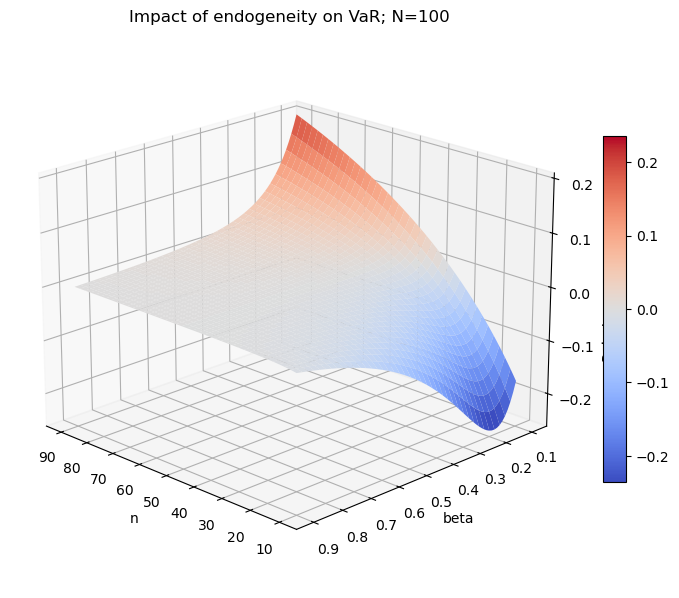

In [108]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (9,9)
n_range, beta_range = np.meshgrid(np.linspace(10,90,81), np.linspace(0.1,0.9,81))
ax = plt.axes(projection = "3d")
surf = ax.plot_surface(n_range, beta_range, VaR_mis_rel.T, cmap = cm.coolwarm, norm = colors.CenteredNorm(vcenter = 0))
plt.colorbar(surf, shrink = 0.5, aspect = 15)
plt.title("Impact of endogeneity on VaR; N=100")
plt.xlabel("n")
plt.ylabel("beta")
ax.set_zlabel("Relative VaR bias")
ax.view_init(elev = 20, azim = 135)
plt.show()

3D plot of the relative bias for granular grid - interactive (to be displayed in a separate window):

In [97]:
%matplotlib qt
plt.rcParams["figure.figsize"] = (16,16)
n_range, beta_range = np.meshgrid(np.linspace(10,90,81), np.linspace(0.1,0.9,81))
ax = plt.axes(projection = "3d")
surf = ax.plot_surface(n_range, beta_range, VaR_mis_rel.T, cmap = cm.coolwarm, norm = colors.CenteredNorm(vcenter = 0))
plt.colorbar(surf, shrink = 0.5, aspect = 15)
plt.title("Impact of endogeneity on VaR; N=100")
plt.xlabel("n")
plt.ylabel("beta")
ax.set_zlabel("Relative VaR bias")
plt.show()

In [111]:
N = 500

In [112]:
# Sparse grid
#n_range = np.arange(25, 451, 25)
#beta_range = np.arange(0.1, 0.91, 0.1)

# Granular grid
n_range = np.arange(10, 491, 5)
beta_range = np.arange(0.1, 0.91, 0.01)

VaR_mis_rel_500 = np.zeros((len(n_range), len(beta_range)))

for k, n in enumerate(n_range):

    for l, beta in enumerate(beta_range):

        true_cov = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    true_cov[i,j] = beta ** 2

        cors_est = np.zeros(N)
        cors_est[:n] = np.sqrt(((n - 1) * beta ** 2 + 1) / n)
        cors_est[n:] = (beta ** 2) / np.sqrt(((n - 1) * beta ** 2 + 1) / n)

        est_cov = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    est_cov[i,j] = cors_est[i] * cors_est[j]

        VaR_mis_rel_500[k, l] = np.sqrt(np.ones(N).dot(est_cov).dot(np.ones(N))) / np.sqrt(np.ones(N).dot(true_cov).dot(np.ones(N))) - 1

Print relative bias for sparse grid:

In [91]:
VaR_mis_rel_500.round(2)

array([[-0.36, -0.24, -0.14, -0.08, -0.05, -0.03, -0.02, -0.01, -0.  ],
       [-0.25, -0.13, -0.07, -0.04, -0.02, -0.01, -0.01, -0.  , -0.  ],
       [-0.17, -0.08, -0.04, -0.02, -0.01, -0.01, -0.  , -0.  , -0.  ],
       [-0.12, -0.06, -0.03, -0.01, -0.01, -0.01, -0.  , -0.  , -0.  ],
       [-0.09, -0.04, -0.02, -0.01, -0.01, -0.  , -0.  , -0.  , -0.  ],
       [-0.06, -0.03, -0.01, -0.01, -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.04, -0.02, -0.01, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.02, -0.01, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.03,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.04,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.05,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , 

3D plot of the relative bias for granular grid - static (to be displayed in notebook):

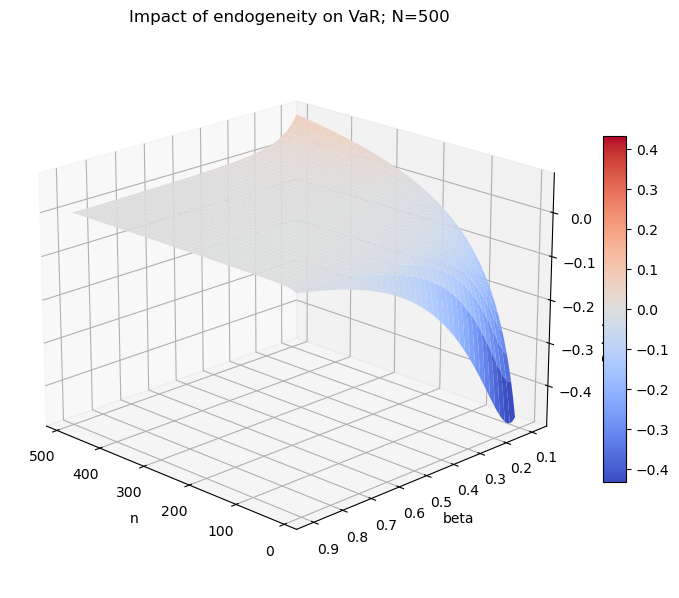

In [113]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (9,9)
n_range, beta_range = np.meshgrid(np.linspace(10,490,97), np.linspace(0.1,0.9,81))
ax = plt.axes(projection = "3d")
surf = ax.plot_surface(n_range, beta_range, VaR_mis_rel_500.T, cmap = cm.coolwarm, norm = colors.CenteredNorm(vcenter = 0))
plt.colorbar(surf, shrink = 0.5, aspect = 15)
plt.title("Impact of endogeneity on VaR; N=500")
plt.xlabel("n")
plt.ylabel("beta")
ax.set_zlabel("Relative VaR bias")
ax.view_init(elev = 20, azim = 135)
plt.show()

3D plot of the relative bias for granular grid - interactive (to be displayed in a separate window):

In [114]:
%matplotlib qt
plt.rcParams["figure.figsize"] = (16,16)
n_range, beta_range = np.meshgrid(np.linspace(10,490,97), np.linspace(0.1,0.9,81))
ax = plt.axes(projection = "3d")
surf = ax.plot_surface(n_range, beta_range, VaR_mis_rel_500.T, cmap = cm.coolwarm, norm = colors.CenteredNorm(vcenter = 0))
plt.colorbar(surf, shrink = 0.5, aspect = 15)
plt.title("Impact of endogeneity on VaR; N=500")
plt.xlabel("n")
plt.ylabel("beta")
ax.set_zlabel("Relative VaR bias")
plt.show()

In [115]:
N = 1000

In [116]:
# Sparse grid
#n_range = np.arange(20, 971, 50)
#beta_range = np.arange(0.1, 0.91, 0.1)

# Granular grid
n_range = np.arange(10, 991, 10)
beta_range = np.arange(0.1, 0.91, 0.01)

VaR_mis_rel_1000 = np.zeros((len(n_range), len(beta_range)))

for k, n in enumerate(n_range):

    for l, beta in enumerate(beta_range):

        true_cov = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    true_cov[i,j] = beta ** 2

        cors_est = np.zeros(N)
        cors_est[:n] = np.sqrt(((n - 1) * beta ** 2 + 1) / n)
        cors_est[n:] = (beta ** 2) / np.sqrt(((n - 1) * beta ** 2 + 1) / n)

        est_cov = np.ones((N,N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    est_cov[i,j] = cors_est[i] * cors_est[j]

        VaR_mis_rel_1000[k, l] = np.sqrt(np.ones(N).dot(est_cov).dot(np.ones(N))) / np.sqrt(np.ones(N).dot(true_cov).dot(np.ones(N))) - 1

Print relative bias for sparse grid:

In [110]:
VaR_mis_rel_1000.round(2)

array([[-0.48, -0.3 , -0.17, -0.1 , -0.06, -0.04, -0.02, -0.01, -0.01],
       [-0.26, -0.11, -0.06, -0.03, -0.02, -0.01, -0.01, -0.  , -0.  ],
       [-0.17, -0.06, -0.03, -0.02, -0.01, -0.01, -0.  , -0.  , -0.  ],
       [-0.11, -0.04, -0.02, -0.01, -0.01, -0.  , -0.  , -0.  , -0.  ],
       [-0.08, -0.03, -0.01, -0.01, -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.05, -0.02, -0.01, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.04, -0.01, -0.01, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.02, -0.01, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.01, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ],
       [ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.02,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , 

3D plot of the relative bias for granular grid - static (to be displayed in notebook):

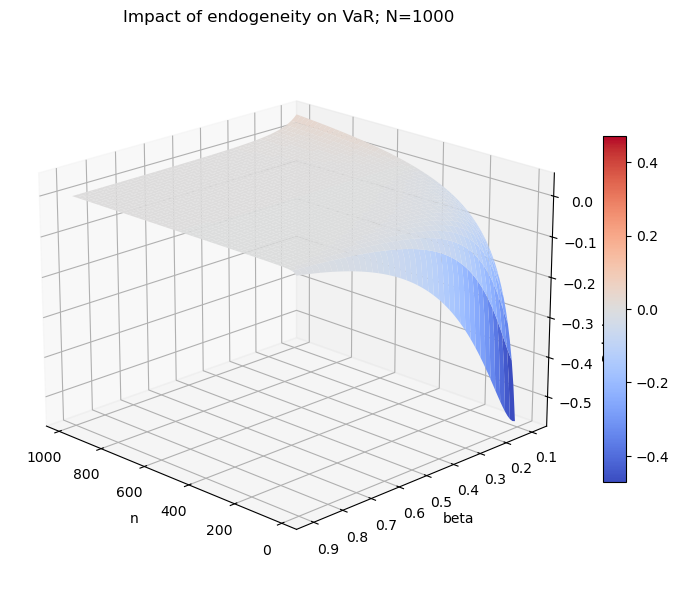

In [117]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (9,9)
n_range, beta_range = np.meshgrid(np.linspace(10,990,99), np.linspace(0.1,0.9,81))
ax = plt.axes(projection = "3d")
surf = ax.plot_surface(n_range, beta_range, VaR_mis_rel_1000.T, cmap = cm.coolwarm, norm = colors.CenteredNorm(vcenter = 0))
plt.colorbar(surf, shrink = 0.5, aspect = 15)
plt.title("Impact of endogeneity on VaR; N=1000")
plt.xlabel("n")
plt.ylabel("beta")
ax.set_zlabel("Relative VaR bias")
ax.view_init(elev = 20, azim = 135)
plt.show()

3D plot of the relative bias for granular grid - interactive (to be displayed in a separate window):

In [118]:
%matplotlib qt
plt.rcParams["figure.figsize"] = (16,16)
n_range, beta_range = np.meshgrid(np.linspace(10,990,99), np.linspace(0.1,0.9,81))
ax = plt.axes(projection = "3d")
surf = ax.plot_surface(n_range, beta_range, VaR_mis_rel_1000.T, cmap = cm.coolwarm, norm = colors.CenteredNorm(vcenter = 0))
plt.colorbar(surf, shrink = 0.5, aspect = 15)
plt.title("Impact of endogeneity on VaR; N=1000")
plt.xlabel("n")
plt.ylabel("beta")
ax.set_zlabel("Relative VaR bias")
plt.show()

## Complex framework

In this section we relax the initial assumptions, and allow weights, volatilities and (true) correlations to vary across different market factors.

### Basic numerical examples

We run the calculations for the following numerical example. We set the following parameters: $n=20$, $N=100$, $T=1000$. We draw weights, volatilities and correlations with systematic component from the uniform distributions:
- $ 𝑤_𝑗 \sim 𝑈[0.025, 0.075] $ for $j=1,…,n$,
- $ 𝜎_𝑖 \sim 𝑈[0.1, 0.3] $ for $i=1,…,N$,
- $ 𝜌_{𝑟_𝑠,𝑟_𝑖} \sim 𝑈[0.2, 0.4] $ for $i=1,…,N$,

and we adjust the weights, so that they sum up to 1: $ \forall_{k=1,...,n} w_k \leftarrow \frac{w_k}{\sum_{j=1}^{n} w_j} $. Then we generate the returns for all market factors.

Parameters

In [119]:
cor_low = 0.2
cor_high = 0.4
n = 20
weight_disp = 0.5
sigma_low = 0.1
sigma_high = 0.3
N = 100
T = 1000

Simulation of weights, sigmas and betas

In [120]:
w = np.random.uniform((1 / n) * (1 - weight_disp), (1 / n) * (1 + weight_disp), n)
w = w / sum(w)
cors = np.random.uniform(cor_low, cor_high, N)
sigmas = np.random.uniform(sigma_low, sigma_high, N)
betas = cors * sigmas

Systematic and idiosyncratic components simulation

In [121]:
s = np.random.normal(0,1,T)
idio = np.random.normal(np.zeros((N,T)), np.diag(sigmas).dot(np.ones((N,T))), (N,T))

Market factors and index returns calculation

In [122]:
r = np.array([betas[i] * s + np.sqrt(1 - cors[i] ** 2) * idio[i] for i in range(N)])
idx = np.array([np.sum(r[:n][:, i] * w) for i in range(T)])

Correlations and covariances between market factors and index returns

In [123]:
cors_est = np.array([np.corrcoef(idx, r[i])[0, 1] for i in range(N)])
covs_est = np.array([np.cov(idx, r[i])[0, 1] for i in range(N)])

In [124]:
covs_cf = (betas[:n] * sum(w * betas[:n]) + w * (sigmas[:n] ** 2) - w * (betas[:n] ** 2))

In [125]:
cors_cf = covs_cf / (sigmas[:n] * np.sqrt(sum(betas[:n] * w) ** 2 + sum((w * sigmas[:n]) ** 2) - sum((w * betas[:n]) ** 2)))

Index and market factors variances and standard deviations

In [126]:
idx.var(), sum(betas[:n] * w) ** 2 + sum((w * sigmas[:n]) ** 2) - sum((w * betas[:n]) ** 2)

(0.005763526956275484, 0.005695370960213097)

In [127]:
idx.std(), np.sqrt(sum(betas[:n] * w) ** 2 + sum((w * sigmas[:n]) ** 2) - sum((w * betas[:n]) ** 2))

(0.07591789615285373, 0.07546768156113647)

In [128]:
sigmas_est = np.array([r[i].std() for i in range(N)])
vars_est = np.array([r[i].var() for i in range(N)])

Recall we assumed $ \sum_{𝑗=1}^{𝑛} 𝑤_𝑗^2 𝛽_𝑗^2 \approx \left( \sum_{𝑗=1}^{𝑛} 𝑤_𝑗 𝛽_𝑗 \right)^2 \sum_{𝑗=1}^{𝑛} 𝑤_𝑗^2 $

In [129]:
sum((w * betas[:n]) ** 2), sum(w ** 2) * (sum(w * betas[:n]) ** 2)

(0.00019446558785838242, 0.00018239243411139632)

Approximation of weighted average $\beta$, i.e., $\hat{\overline{\beta}}$, and comparison with the actual value

In [130]:
aa_beta = np.sqrt((idx.var() - sum((w * sigmas_est[:n]) ** 2)) / (1 - sum(w ** 2)))

In [131]:
aa_beta, sum(w * betas[:n])

(0.0593700987250102, 0.058712340223894516)

Adjusted coefficients as derived in README

In [132]:
betas_com_adj = (aa_beta - np.sqrt(aa_beta ** 2 - 4 * w * (covs_est[:n] - w * (sigmas_est[:n] ** 2)))) / (2 * w)
cors_com_adj = betas_com_adj / sigmas_est[:n]

In [133]:
betas_ncom_adj = covs_est[n:] / aa_beta
cors_ncom_adj = betas_ncom_adj / sigmas_est[n:]

#### Comparison of adjusted and unadjusted estimated correlations vs. true correlations

Below we present scatter plots comparing estimated correlations and true correlations. Unadjusted correlations are represented by orange dots, while adjusted correlations are represented by blue dots. The red line represents the perfect estimations (for the points lying on this line the estimated correlation is equal to the true one). It determines the center of distribution for an unbiased estimator.

In [134]:
plt.rcParams["figure.figsize"] = (6,6)
%matplotlib inline

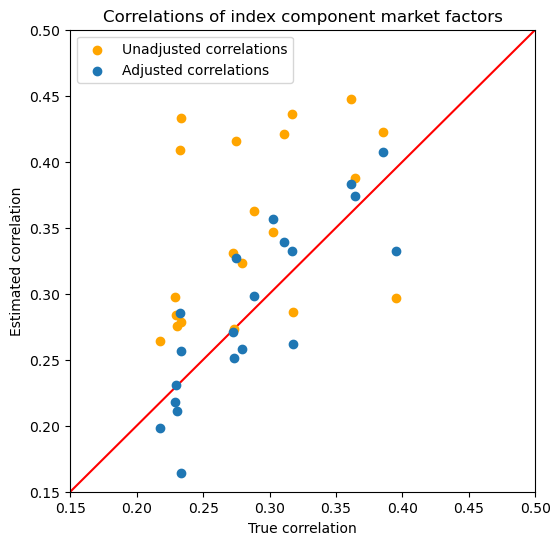

In [137]:
plt.plot([0, 1], [0, 1], color = "red", zorder = 0)
plt.scatter(cors[:n], cors_est[:n], color = "orange", label = "Unadjusted correlations")
plt.scatter(cors[:n], cors_com_adj, label = "Adjusted correlations")
plt.xlim([0.15, 0.5])
plt.ylim([0.15, 0.5])
plt.legend()
plt.title("Correlations of index component market factors")
plt.xlabel("True correlation")
plt.ylabel("Estimated correlation")
plt.show()

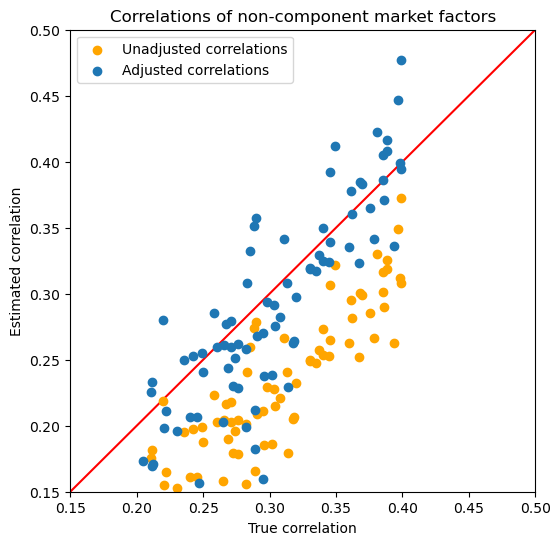

In [138]:
plt.plot([0, 1], [0, 1], color = "red", zorder = 0)
plt.scatter(cors[n:], cors_est[n:], color = "orange", label = "Unadjusted correlations")
plt.scatter(cors[n:], cors_ncom_adj, label = "Adjusted correlations")
plt.xlim([0.15, 0.5])
plt.ylim([0.15, 0.5])
plt.legend()
plt.title("Correlations of non-component market factors")
plt.xlabel("True correlation")
plt.ylabel("Estimated correlation")
plt.show()

In [139]:
# Compare fit for different estimators
#model = sm.OLS(cors[n:], add_constant(cors_ncom_adj), hasconst = True)
#results = model.fit()
#results.summary()

### Impact on VaR

For the parameters defined (drawn) above, we calculate 99% VaR with the same methods as in case of the simple framework.

True VaR

In [140]:
true_cov = np.ones((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            true_cov[i,j] = sigmas[i] ** 2
        else:
            true_cov[i,j] = betas[i] * betas[j]

In [141]:
true_VaR = np.sqrt(np.ones(N).dot(true_cov).dot(np.ones(N))) * norm.ppf(0.99)
true_VaR

15.056248154087259

VaR based on covariance estimator obtained through systematic component

In [142]:
emp_cov = np.ones((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            emp_cov[i,j] = sigmas_est[i] ** 2
        else:
            emp_cov[i,j] = cors_est[i] * sigmas_est[i] * cors_est[j] * sigmas_est[j]

In [143]:
VaR_est = np.sqrt(np.ones(N).dot(emp_cov).dot(np.ones(N))) * norm.ppf(0.99)
VaR_est

12.988710863730496

VaR based on adjusted covariance estimator obtained through systematic component

In [144]:
cors_adj = np.zeros(N)
cors_adj[:n] = cors_com_adj
cors_adj[n:] = cors_ncom_adj

In [145]:
emp_cov_adj = np.ones((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            emp_cov_adj[i,j] = sigmas_est[i] ** 2
        else:
            emp_cov_adj[i,j] = cors_adj[i] * sigmas_est[i] * cors_adj[j] * sigmas_est[j]

In [146]:
VaR_est_adj = np.sqrt(np.ones(N).dot(emp_cov_adj).dot(np.ones(N))) * norm.ppf(0.99)
VaR_est_adj

14.620115170913332

VaR based on standard covariance estimator

In [147]:
VaR_emp_cov = np.sqrt(np.ones(N).dot(pd.DataFrame(r.transpose()).cov()).dot(np.ones(N))) * norm.ppf(0.99)
VaR_emp_cov

14.766057554934497

Comparison of estimated VaRs vs. the true VaR

In [148]:
VaR_est / true_VaR, VaR_est_adj / true_VaR, VaR_emp_cov / true_VaR

(0.8626791170551014, 0.9710330901357035, 0.980726234305989)

#### 1000 simulations

Similarly, for the same parameters, we simulate the returns 1000 times and calculate 99% VaR with a use of the same methods. For estimated VaRs we calculate means and standard deviations across 1000 simulations, and compare the means against the true VaR.

In [149]:
var_cov_sys = []
var_cov_sys_adj = []
var_cov = []

for k in range(1000):

    s = np.random.normal(0,1,T)
    idio = np.random.normal(np.zeros((N,T)), np.diag(sigmas).dot(np.ones((N,T))), (N,T))
    r = np.array([betas[i] * s + np.sqrt(1 - cors[i] ** 2) * idio[i] for i in range(N)])
    idx = np.array([np.sum(r[:n][:, i] * w) for i in range(T)])
    cors_est = np.array([np.corrcoef(idx, r[i])[0, 1] for i in range(N)])
    covs_est = np.array([np.cov(idx, r[i])[0, 1] for i in range(N)])
    sigmas_est = np.array([r[i].std() for i in range(N)])
    vars_est = np.array([r[i].var() for i in range(N)])
    aa_beta = np.sqrt((idx.var() - sum((w * sigmas_est[:n]) ** 2)) / (1 - sum(w ** 2)))

    betas_com_adj = (aa_beta - np.sqrt(np.array([max((aa_beta ** 2 - 4 * w * (covs_est[:n] - w * (sigmas_est[:n] ** 2)))[i], 0) for i in range(n)]))) / (2 * w)
    cors_com_adj = betas_com_adj / sigmas_est[:n]
    betas_ncom_adj = covs_est[n:] / aa_beta
    cors_ncom_adj = betas_ncom_adj / sigmas_est[n:]

    emp_cov = np.ones((N,N))
    for i in range(N):
        for j in range(N):
            if i == j:
                emp_cov[i,j] = sigmas_est[i] ** 2
            else:
                emp_cov[i,j] = cors_est[i] * sigmas_est[i] * cors_est[j] * sigmas_est[j]
    var_cov_sys.append(np.sqrt(np.ones(N).dot(emp_cov).dot(np.ones(N))) * norm.ppf(0.99))

    cors_adj = np.zeros(N)
    cors_adj[:n] = cors_com_adj
    cors_adj[n:] = cors_ncom_adj
    emp_cov_adj = np.ones((N,N))
    for i in range(N):
        for j in range(N):
            if i == j:
                emp_cov_adj[i,j] = sigmas_est[i] ** 2
            else:
                emp_cov_adj[i,j] = cors_adj[i] * sigmas_est[i] * cors_adj[j] * sigmas_est[j]
    var_cov_sys_adj.append(np.sqrt(np.ones(N).dot(emp_cov_adj).dot(np.ones(N))) * norm.ppf(0.99))

    var_cov.append(np.sqrt(np.ones(N).dot(pd.DataFrame(r.transpose()).cov()).dot(np.ones(N))) * norm.ppf(0.99))

In [150]:
pd.DataFrame({'Value': ['Mean', 'Relative difference', 'Standard deviation'], 'VaR_true': [true_VaR.round(2), np.nan, np.nan], 'VaR_cov_sys': [np.mean(var_cov_sys).round(2), format(np.mean(var_cov_sys) / true_VaR - 1, ".2%"), np.std(var_cov_sys).round(2)], 'VaR_cov_sys_adj': [np.mean(var_cov_sys_adj).round(2), format(np.mean(var_cov_sys_adj) / true_VaR - 1, ".2%"), np.std(var_cov_sys_adj).round(2)], 'VaR_cov': [np.mean(var_cov).round(2), format(np.mean(var_cov) / true_VaR - 1, ".2%"), np.std(var_cov).round(2)]}).set_index('Value')

,VaR_true,VaR_cov_sys,VaR_cov_sys_adj,VaR_cov
Value,,,,
Mean,15.06,13.29,15.09,15.04
Relative difference,NaN,-11.74%,0.22%,-0.09%
Standard deviation,NaN,0.36,0.38,0.33
